<a href="https://colab.research.google.com/github/sciencelee/mod4-xray-pneumonia-ML/blob/main/mod4_xrays_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



# INTRODUCTION
In this project we will create a Machine Learning model to classify chest x-ray images as positive or negative for pneumonia.  

Pneumonia is an oft misdiagnosed illness.  It's symptoms mimics: upper respiratory infections, influenza, cold, pleurisy, sinus infection, and seasonal viruses.  Pneumonia is a potentially life threatening condition with a mortality rate of 3.3%, and much higher when missed on the first visit. A hospital xray costs only $44 in the US health system.  

Pneumonia is also overly diagnosed when other underlying causes exist.  It leads to over prescribing of antibiotics, increased mortality, exposure to malpractice, and missing serious diseases such as: lung cancer, TB, pulmonary and cardiac disorders.  

Proper identification of a simple chest xray could help mitigate.

The purpose of this project is to create a proof of concept model for helping identify pneumonia in pediatric patients.


#NON-TECHNICAL PRESENTATION
https://docs.google.com/presentation/d/1SdlY32Ac2sYzPgI47XhXPA95o7LxSLlrMaHC1BYpf8Q/edit?usp=sharing

#WEB APPLICATION
A working web app of this project can be found at https://xray-pred.herokuapp.com/.

A client can submit medical images to the site and receive a prediction (Normal/Pneumonia).

The github repo for this webapp project https://github.com/sciencelee/flask-xray2

# DATASET
The full dataset used in this project can be found [here](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia) at kaggle.com.  

The kaggle dataset is taken adapted from the [original images](https://data.mendeley.com/datasets/rscbjbr9sj/3) at Mendeley Data.

The labeled dataset contains 1583 normal chest xray images, and 4274 with pneumonia. The original images are greater than 1200x1200 pixels grayscale.

#PROJECT INITIALIZATION



##Google Drive 
This project is written in Google Colab.  The image folders are stored in These blocks mount the users google drive.  The chest xrays are stored in the path location of the drive.

The structure of the xray images within the google folder is as shown. If you would like to recreate the project, all normal labeled images go in the "NORMAL ALL" folder, and all pneumonia labeled go in the 'PNEUMONIA ALL' folder.  This notebook will randomly place the desired `train test val` ratios of randomized images into the correct folders for reading into the datasets used in our model.  

```
chest_xray  
  └───NORMAL_ALL (contains all normal imgs)
  └───PNEUMONIA_ALL (contains all pneumonia imgs)
  └───train 
  │   └───NORMAL
  │   └───PNEUMONIA
  └───test
  │   └───NORMAL
  │   └───PNEUMONIA
  └───val
      └───NORMAL
      └───PNEUMONIA
```

The code below connects this ipynb to Google Drive.  To give access to your drive, you will need to give authorization.

In [53]:
# to get local files from the repo, run next line
# this will not get dataset
#!git clone https://github.com/sciencelee/mod4-xray-pneumonia-ML


# Owner of repo will add share permissions for folder chest_xray.  This will also provide dataset
# After shared, new user can mount drive with following code without modifications
from google.colab import drive # import drive from google colab

drive.mount('/content/drive') # we mount the google drive at /content/drive

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Imports
Import all of the necessary libraries for this project

In [39]:
import datetime
import os
import time
import shutil
import datetime
from random import shuffle, seed


import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

from PIL import Image
import scipy
from scipy import ndimage
from sklearn.metrics import accuracy_score, confusion_matrix
from keras import models, layers, optimizers
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.preprocessing import image
from keras.models import load_model
from keras.utils import plot_model
from keras.layers import SpatialDropout2D


%matplotlib inline

np.random.seed(123)

Store the paths to the working directory in Google Drive.

In [40]:
path = '/content/drive/MyDrive/chest_xray'
all_normal_folder = path + '/NORMAL_ALL/'
all_pneumonia_folder = path + '/PNEUMONIA_ALL/'

test_folder = path + '/test/'
train_folder = path + '/train/'
val_folder = path + '/val/'


# BUILD DATASET
This section selects the dataset from existing files, and sorts the images into appropriate folders.

Skip to the quick load section if you are not changing the dataset distribution.*italicized text*



## Building our Train, Test, and Validation Datasets
We will make lists of all of the image names for NORMAL and PNEUMONIA chest xrays.  Then we can divy up the images into individual folders for later use.

I will also use this opportunity to randomize the images, and select the size of the dataset to use.  I will start with a small sets prior to building the final model.

We have two folders.  One for normal images, and one for pnemonia xray images.  In order to determine redistribute the images in a way different than original set on kaggle, we make a list of all the normal images, and all the pneumonia images and we shuffled each. 

This will give us a randomized list of all images that we can chop up into smaller datasets as need.

In [ ]:
# Time: 1min

def shuffle_folder(folder_path, image_type):
  '''
  Returns a shuffled list of filenames from a folder.
            Parameters:
                    folder_path (string): path of the folder to with files I want
                    image_type (string): What types of files (normal or pneumonia)
            Returns:
                    filenames (list): shuffled list of all filenames in folder
  '''  
  filenames = [file for file in os.listdir(folder_path)]
  shuffle(filenames)
  print('There are {} {} xray images.'.format(len(filenames), image_type))
  return filenames



# Make a list of all normal images
normal_imgs = shuffle_folder(all_normal_folder, 'normal')

# Make a list of all pneumonia images
pneumonia_imgs = shuffle_folder(all_pneumonia_folder, 'pneumonia')

There are 1583 normal xray images.
There are 4274 pneumonia xray images.


## Split up our data into train, test, and val sets
In the list train_test_val, we set up the distribution/percent desired for each dataset.  Values are entered as floats.  If I use [0.75, 0.25, 0.25] for this, we would images would be divided into 75% train, 25% test, and 25% val.

We take our previously shuffled list of filenames, and make each into three smaller lists to divy them up.

We also choose the size of our dataset (float from 0 to 1) to represent the percentage of images we want to use.  We want to reduce the size for testing.

In [ ]:
# https://docs.python.org/3/library/shutil.html#shutil

# set distribution of datasets
train_test_val = [0.8, 0.1, 0.1] # must add to 1.0, these are the distributions

# What percentage of the dataset are we using
size_dataset = 1 # what percentage of dataset are we using?

# NORMAL data indices
# indices for train, test, val
n_images_norm = int(round(len(normal_imgs) * size_dataset))

print(
'''
Percent of images used: {:.0%}. (lower this to speed up model iterations)
Train//Test//Val Split: {:.0%}, {:.0%}, {:.0%}
'''.format(size_dataset, train_test_val[0], train_test_val[1], train_test_val[2]))

# get the correct indices to chop up my NORMAL images from a shuffled list
norm_train_index = int(round(n_images_norm * train_test_val[0]))
norm_test_index = int(norm_train_index + round(n_images_norm * train_test_val[1]))
norm_val_index = min(norm_test_index + int(round(n_images_norm * train_test_val[2])), n_images_norm-1)

print('NORMAL xrays\nTotal images: {}\nIndices: {}, {}, {}'.format(n_images_norm, norm_train_index, norm_test_index, norm_val_index)) 

# PNEUMONIA data indices
# indices for train, test, val
n_images_pneu = int(round(len(pneumonia_imgs) * size_dataset))

# get the correct indices to chop up my PNEUMONIA images from a shuffled list
pneu_train_index = int(round(n_images_pneu * train_test_val[0]))
pneu_test_index = int(pneu_train_index + round(n_images_pneu * train_test_val[1]))
pneu_val_index = min(pneu_test_index + int(round(n_images_pneu * train_test_val[2])), n_images_pneu-1)


print('\nPNEUMONIA xrays\nTotal images: {}\nIndices: {}, {}, {}'.format(n_images_pneu, pneu_train_index, pneu_test_index, pneu_val_index)) 


Percent of images used: 100%. (lower this to speed up model iterations)
Train//Test//Val Split: 80%, 10%, 10%

NORMAL xrays
Total images: 1583
Indices: 1266, 1424, 1582

PNEUMONIA xrays
Total images: 4274
Indices: 3419, 3846, 4273


Now that we have all of the names of images in a list, and we have the indices for the split, we will copy image files into the appropriate folders so we can use 'flow_from_directory' method in ImageDataGenerator.

This may take a while.  This is definitely not something I would try on a larger dataset, but it works for this size and gives us some flexibility in training the model.

In [ ]:
# ONLY RUN THIS CELL IF YOU WANT TO RECREATE THE DATASET. (1hr)
# ⏰ ⏰ ⏰ ⏰ ⏰ ⏰


answer = input("Are you sure you want to continue?")  


# if time, make function with code below.
if answer.upper() in ['Y', 'YES']:

  # empty all of the folders first
  shutil.rmtree(test_folder, ignore_errors=True)
  shutil.rmtree(train_folder, ignore_errors=True)
  shutil.rmtree(val_folder, ignore_errors=True)

  os.mkdir(test_folder)
  os.mkdir(test_folder + 'NORMAL')
  os.mkdir(test_folder + 'PNEUMONIA')
  os.mkdir(train_folder)
  os.mkdir(train_folder + 'NORMAL')
  os.mkdir(train_folder + 'PNEUMONIA')
  os.mkdir(val_folder)
  os.mkdir(val_folder + 'NORMAL')
  os.mkdir(val_folder + 'PNEUMONIA')

  # fill them back up with selected images

  # NORMAL images first
  for image in normal_imgs[:norm_train_index]:
    shutil.copyfile(all_normal_folder + image, train_folder + 'NORMAL/' + image)
  else:
    print(train_folder + 'NORMAL', 'complete')

  for image in normal_imgs[norm_train_index:norm_test_index]:
    shutil.copyfile(all_normal_folder + image, test_folder + 'NORMAL/' + image)
  else:
    print(test_folder + 'NORMAL', 'complete')

  for image in normal_imgs[norm_test_index:norm_val_index]:
    shutil.copyfile(all_normal_folder + image, val_folder + 'NORMAL/' + image)
  else:
    print(val_folder + 'NORMAL', 'complete')

  # PNEUMONIA images
  for image in pneumonia_imgs[:pneu_train_index]:
    shutil.copyfile(all_pneumonia_folder + image, train_folder + 'PNEUMONIA/' + image)
  else:
    print(train_folder + 'PNEUMONIA', 'complete')

  for image in pneumonia_imgs[pneu_train_index:pneu_test_index]:
    shutil.copyfile(all_pneumonia_folder + image, test_folder + 'PNEUMONIA/' + image)
  else:
    print(test_folder + 'PNEUMONIA', 'complete')

  for image in pneumonia_imgs[pneu_test_index:pneu_val_index]:
      shutil.copyfile(all_pneumonia_folder + image, val_folder + 'PNEUMONIA/' + image)
  else:
    print(val_folder + 'PNEUMONIA', 'complete')


Are you sure you want to continue?y
/content/drive/MyDrive/chest_xray/train/NORMAL complete
/content/drive/MyDrive/chest_xray/test/NORMAL complete
/content/drive/MyDrive/chest_xray/val/NORMAL complete
/content/drive/MyDrive/chest_xray/train/PNEUMONIA complete
/content/drive/MyDrive/chest_xray/test/PNEUMONIA complete
/content/drive/MyDrive/chest_xray/val/PNEUMONIA complete


##Downsampling and generating datasets
Now that we have our images separated into approrpriate folders, we will use ImageDataGenerator to pull them as a batch from the train, test, and val folders.  

In the process, we will downsample our images.  The typical unaltered image is about 1200x1200 (1.4 Megapixels).  We reduce them to 150x150 (22.5k pixels).  This is a loss of  98% of our original data, but will significantly speed up the training process.

In [ ]:
# get all the data in the directory and downsample it
# you can also choose to just unpickle the image data
# ⏰  (30s)

print('TEST:')
n = len(os.listdir(test_folder + 'PNEUMONIA')) + len(os.listdir(test_folder + 'NORMAL'))
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        test_folder, 
        target_size=(150, 150),
        batch_size=n
        ) 

print('\nVAL:')
n = len(os.listdir(val_folder + 'PNEUMONIA')) + len(os.listdir(val_folder + 'NORMAL'))
val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        val_folder, 
        target_size=(150, 150),
        batch_size=n
        )

print('\nTRAIN:')
n = len(os.listdir(train_folder + 'PNEUMONIA')) + len(os.listdir(train_folder + 'NORMAL'))
train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        train_folder, 
        target_size=(150, 150),
        batch_size=n
        )


 
# I ENDED ON A 80/10/10 ratio in the folders, but experiemented with 60/20/20 first.  
# Results were better with more training images

TEST:
Found 585 images belonging to 2 classes.

VAL:
Found 585 images belonging to 2 classes.

TRAIN:
Found 4685 images belonging to 2 classes.


The following lines will generate my images and labels that I will use to create my models.  The generators will output labels (0 for normal, and 1 for pneumonia) for the labels.  The images are np matrices.

In [ ]:
# create the data sets. 
# you can also choose to just unpickle with the block above
# ⏰ ⏰ ⏰ ⏰ ⏰ ⏰
answer = input("Are you sure you want to create new datasets?  (Expect 30 min wait): ")

if answer.lower() in ["y", 'yes']:
  # load them up anew
  test_images, test_labels = next(test_generator)
  print('Test')
  val_images, val_labels = next(val_generator)
  print('Val')
  train_images, train_labels = next(train_generator)
  print('Train')



Are you sure you want to create new datasets?  (Expect 30 min wait): n


In [ ]:
# the last block took soooo long, i want to pickle it

import pickle

file_location = "/content/drive/MyDrive/chest_xray/big_image_sets.pkl"

data = [test_images, test_labels, val_images, val_labels, train_images, train_labels]
with open(file_location, "wb") as f:
    pickle.dump(data, f)

# To retrieve it later...
# with open(file_location, "rb") as f:
#      test_images, test_labels, val_images, val_labels, train_images, train_labels = pickle.load(f)

# QUICK LOAD (instead of dataset build)
Instead of rebuilding the entire dataset and loading images with the Project Setup above, use this section to simply load the already assembled and downsampled data.

In [41]:
# To load up the pickled image datasets, run this block
import pickle


my_file = "/content/drive/MyDrive/chest_xray/big_image_sets.pkl"
with open(my_file, "rb") as f:
     test_images, test_labels, val_images, val_labels, train_images, train_labels = pickle.load(f)

# IMAGE EXPLORATORY DATA ANALYSIS

## A survey of images
First, we will just examine an image from the dataset to see investigate properties and color scales.  The images in the dataset are not uniform.  

The images have varying height, width, pixels, and contrast.  Some are more in portrait mode, and others in landscape.  Some show a significant amount of arms or skull. 

This are also a wide variety of ages of the patient, from infants to what seems like roughly adult bone structures.  The younger patients sometimes have awkward poses or are twisting in the picture.  Some patients are hooked up to EKG pads during the xray.  Most images have some writing on them to identify right side.

1496x1952 image. Single color channel.
Max pixel value: 255
Min pixel value: 0
Mean value: 110.20
Std Dev: 65.53


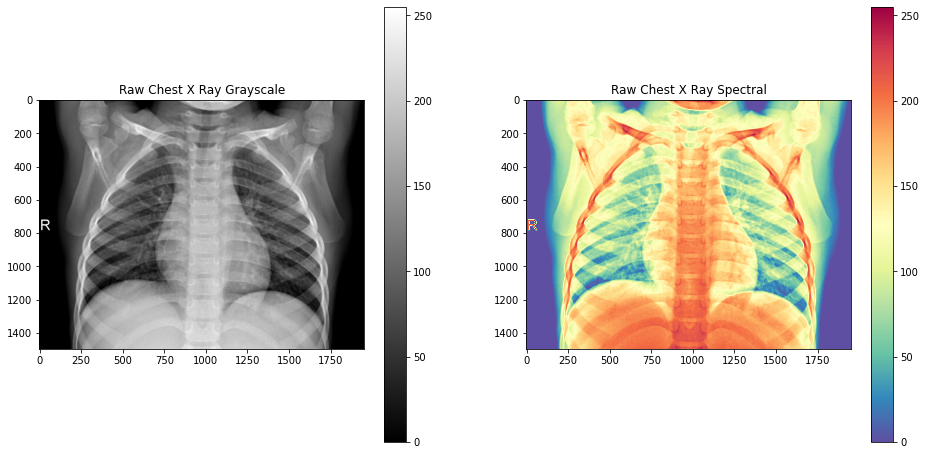

In [ ]:
# Original image investigation
filename = all_normal_folder + os.listdir(all_normal_folder)[337]
sample_img = plt.imread(filename)

plt.figure(figsize=[16,8])
plt.subplot(121) 
plt.imshow(sample_img, cmap='gray')
plt.colorbar()
plt.title('Raw Chest X Ray Grayscale')

plt.subplot(122) 
plt.imshow(sample_img, cmap='Spectral_r')
plt.colorbar()
plt.title('Raw Chest X Ray Spectral')

print("{}x{} image. Single color channel.".format(sample_img.shape[0], sample_img.shape[1]))
print('Max pixel value: {}\nMin pixel value: {}'.format(sample_img.max(), sample_img.min()))
print('Mean value: {:.2f}\nStd Dev: {:.2f}'.format(sample_img.mean(), sample_img.std()))

Now that we have downsampled the pics, we can take a look at our 150x150 pics.  Some of the images have odd aspect ratios, but the features are all still visible at this resolution.  We can also see the difference between pneumonia and normal images. 

Image 8 is bacterial pneumonia.
Image 1 is viral pneumonia
Image 2 is normal.

When looking at these images, we can see that it is more difficult for the human eye to distinguish between normal and viral pneumonia images than between normal and bacterial pneumonia which have obvious hazy smudges on the image. 

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


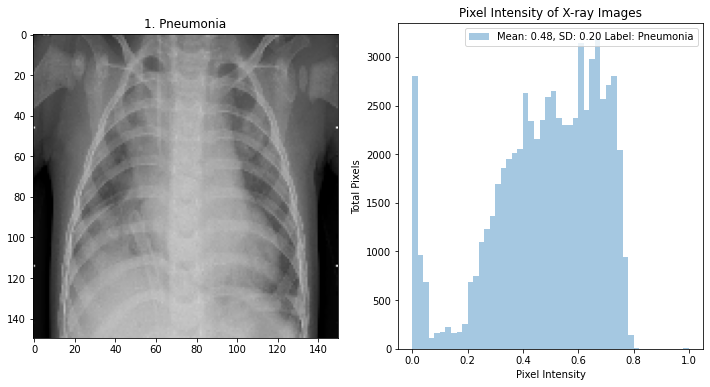

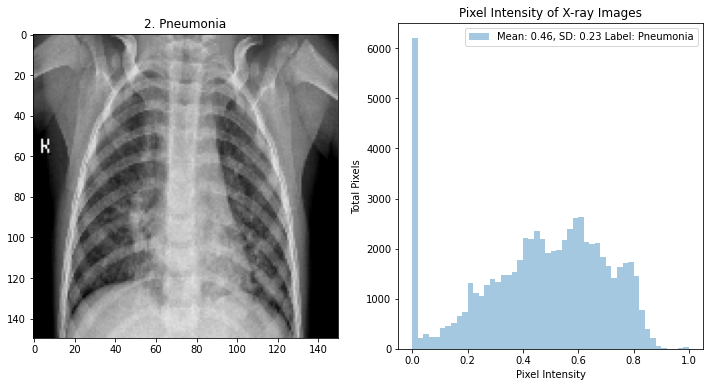

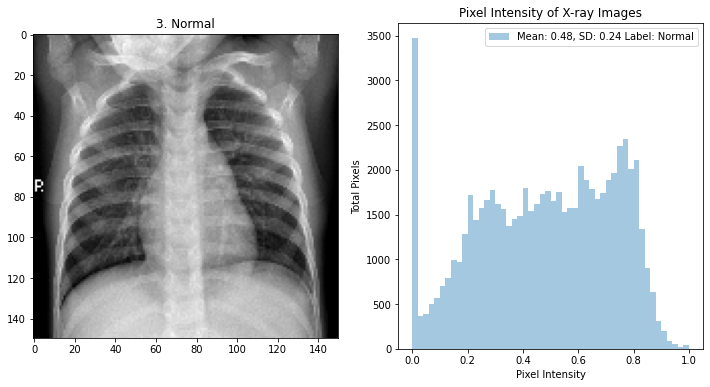

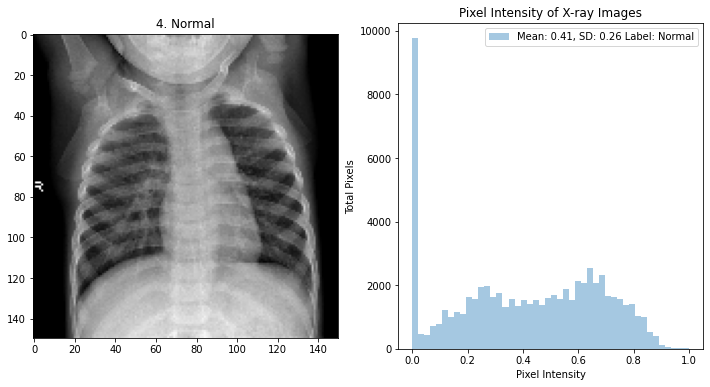

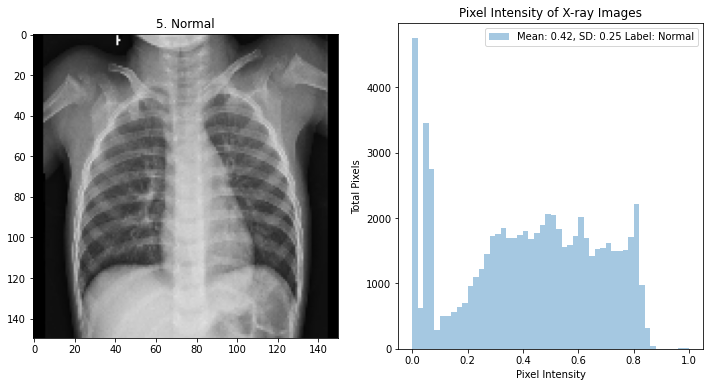

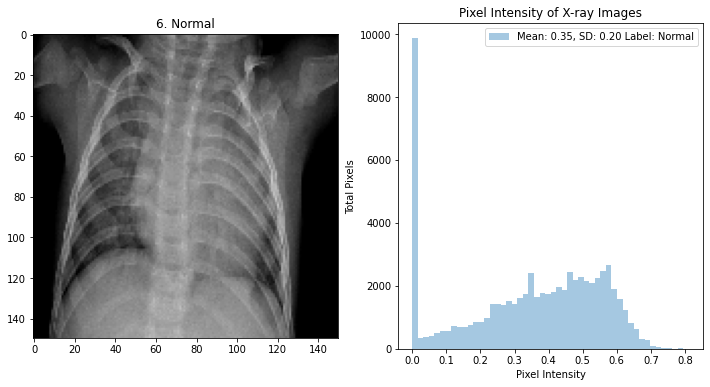

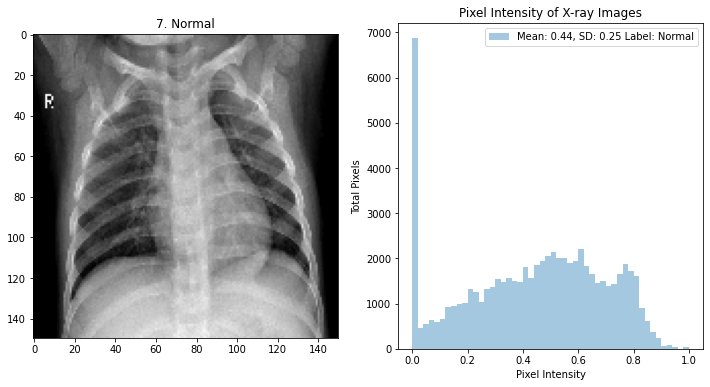

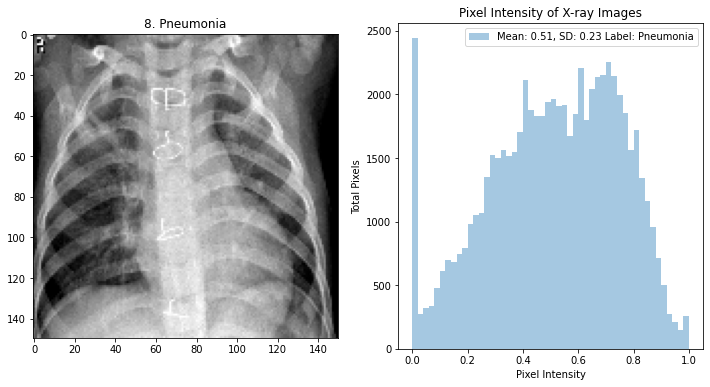

In [ ]:

for i in range(8):
  plt.figure(figsize=(12,6))  # change the size of figure!
  plt.subplot(121)
  my_img = train_images[i]
  classification = 'Normal' if train_labels[i][1]==0 else 'Pneumonia'

  plt.imshow(my_img)
  plt.title('{}. {}'.format(i + 1, classification))
  label = "Mean: {:.2f}, SD: {:.2f} Label: {}".format(np.mean(my_img), np.std(my_img), classification)
  
  plt.subplot(122)
  sns.distplot(my_img,
              label=label,
              kde=False)
  plt.legend()
  plt.title('Pixel Intensity of X-ray Images')
  plt.xlabel('Pixel Intensity')
  plt.ylabel('Total Pixels')
  plt.show()



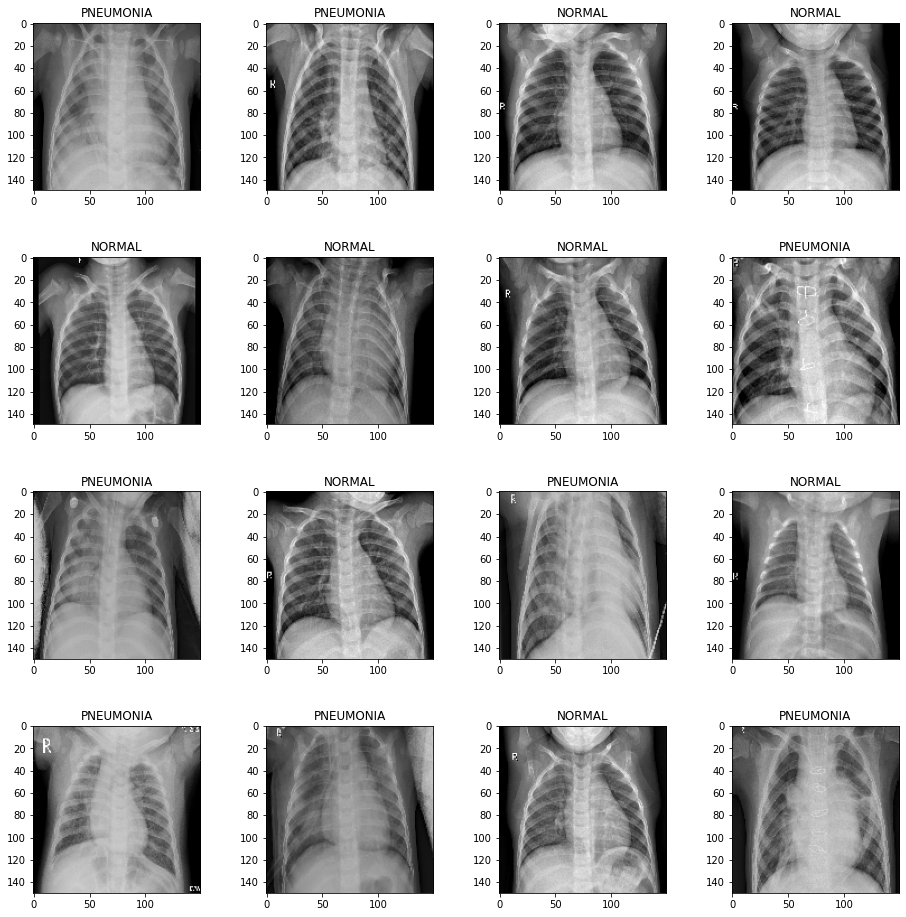

In [ ]:
# DOWNSAMPLED PICS
plt.figure(figsize=(16,16))  # change the size of figure!

for i in range(16):
    img = train_images[i]
    image_label = 'NORMAL' if train_labels[i][1] == 0 else 'PNEUMONIA'

    plt.subplot(4, 4, i+1)
    plt.imshow(img)
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.4)
    plt.title(image_label)  # Plot title here!!!

plt.show()

I also notice that the pneumonia images are a lot brighter for the most part, so I decided to count up all of the black pixels to see if there was an obvious difference.  The normal images indeed have twice as many pure black pixels.

Another, more important thing we observe is that there is a big weight imbalance between normal and pneumonial images.

In [ ]:
# This block grabs some basic stats for all downsampled images

def print_stats(title, my_stats, pixels, n):
    print(title + " Pixel Intensity (n = {})".format(n))
    print('Mean:             {:.3f}'.format(my_stats[0]))
    print('Std:              {:.3f}'.format(my_stats[1]))
    print('Black (0) Pixels: {:.2f}%'.format(my_stats[2] / pixels * 100))
    print('White (1) Pixels: {:.2f}%'.format(my_stats[3] / pixels * 100))


def some_stats(images, labels):
  p_stats = [0, 0, 0, 0] # mean std black white
  n_stats = [0, 0, 0, 0]
  n_p = 0 # n pneu
  n_n = 0 # n normal
  pixels = len(images[0]) * len(images[0][0]) * 3 #3 channels

  for i in range(len(images)):
      my_img = images[i].flatten()
      if labels[i][1] == 1:
          n_p += 1
          p_stats[0] += my_img.mean()
          p_stats[1] += np.std(my_img)
          p_stats[2] += np.count_nonzero(my_img == 0)
          p_stats[3] += np.count_nonzero(my_img == 1)

      else:
          n_n += 1
          n_stats[0] += img.mean()
          n_stats[1] += img.std()
          n_stats[2] += np.count_nonzero(my_img == 0)
          n_stats[3] += np.count_nonzero(my_img == 1)

  else:
    n_stats = np.array(n_stats) / n_n
    p_stats = np.array(p_stats) / n_p
  
  weight_normal = n_n / (n_n + n_p)
  weight_pneumonia = 1 - weight_normal 
  print('Dataset Imbalance: {:.1f} Normal, {:.1f} Pneumonia'.format(weight_normal * 100, weight_pneumonia * 100))
  print()
  print_stats('Normal', n_stats, pixels, n_n)
  print()
  print_stats('Pneumonia', p_stats, pixels, n_p)

# function just prints out some stats of interest from downsampled data
some_stats(train_images, train_labels)

Dataset Imbalance: 27.0 Normal, 73.0 Pneumonia

Normal Pixel Intensity (n = 1266)
Mean:             0.491
Std:              0.210
Black (0) Pixels: 7.65%
White (1) Pixels: 0.07%

Pneumonia Pixel Intensity (n = 3419)
Mean:             0.483
Std:              0.217
Black (0) Pixels: 3.81%
White (1) Pixels: 0.04%


Our images are indeed 150x150.  We see that they have three channels RGB.  They are actually grayscale images, but all three channels are identical.  No need to change the image going in.



In [ ]:
train_images[0].shape

(150, 150, 3)

Here are some basic stats on my downsampled images and labels.  We verify the shapes are as expected for all datasets.

In [ ]:
# Explore your dataset again
m_train = train_images.shape[0]
num_px = train_images.shape[1]
m_test = test_images.shape[0]
m_val = val_images.shape[0]

print ("Number of training samples: " + str(m_train))
print ("Number of testing samples: " + str(m_test))
print ("Number of validation samples: " + str(m_val))
print ("train_images shape: " + str(train_images.shape))
print ("train_labels shape: " + str(train_labels.shape))
print ("test_images shape: " + str(test_images.shape))
print ("test_labels shape: " + str(test_labels.shape))
print ("val_images shape: " + str(val_images.shape))
print ("val_labels shape: " + str(val_labels.shape))

Number of training samples: 4685
Number of testing samples: 585
Number of validation samples: 585
train_images shape: (4685, 150, 150, 3)
train_labels shape: (4685, 2)
test_images shape: (585, 150, 150, 3)
test_labels shape: (585, 2)
val_images shape: (585, 150, 150, 3)
val_labels shape: (585, 2)


For the next cell, we just reshape our images so that they are a 'flat' 150x150x3 input so we can do a baseline model.  

We will retain the full images so we can later do a CNN which requires the shape to do 2Dconv layers.

In [ ]:
train_img = train_images.reshape(train_images.shape[0], -1)
test_img = test_images.reshape(test_images.shape[0], -1)
val_img = val_images.reshape(val_images.shape[0], -1)

print(train_img.shape)
print(test_img.shape)
print(val_img.shape)

(4685, 67500)
(585, 67500)
(585, 67500)


rehape the labels which only need a single result (0 or 1). Currently, they have a column for pneumonia and one for normal which is unecessary.  We choose everything in the first column which is normal.

In [ ]:
# use labels[: 1] so that we have pneumonia as 1 and normal as 0
train_y = np.reshape(train_labels[:,1], (train_img.shape[0],1))
test_y = np.reshape(test_labels[:,1], (test_img.shape[0],1))
val_y = np.reshape(val_labels[:,1], (val_img.shape[0],1))

In [ ]:
print('Before:', train_labels[0])
print("After:", train_y[0])

Before: [0. 1.]
After: [1.]


#MODEL 1: Baseline Model
We will send in a flat "150 \* 150 \* 3 = 67500" matrix for our input, and do it as we would for any Neural Network using Dense layers.

We chose to use an input layer, three hidden layers, and an output to a single 

##Build Model

In [ ]:
# Build a baseline fully connected model
np.random.seed(123)
model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(67500,))) # 2 hidden layers
model.add(layers.Dense(12, activation='relu'))
model.add(layers.Dense(6, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

## Train Model
Vanilla model.  We choose some basic numbers.  I did minimal tuning of this model since it is our baseline.  I adjusted the number of epochs down to 30.

In [ ]:
model.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy'])

hist = model.fit(train_img,
                    train_y,
                    epochs=30,
                    batch_size=20,
                    steps_per_epoch=100,
                    validation_data=(val_img, val_y))

Epoch 1/30
100/100 [==============================] - 1s 13ms/step - loss: 0.5523 - accuracy: 0.7230 - val_loss: 0.4890 - val_accuracy: 0.7299
Epoch 2/30
100/100 [==============================] - 1s 11ms/step - loss: 0.4382 - accuracy: 0.8055 - val_loss: 0.3406 - val_accuracy: 0.8752
Epoch 3/30
100/100 [==============================] - 1s 11ms/step - loss: 0.4067 - accuracy: 0.8222 - val_loss: 0.3334 - val_accuracy: 0.8632
Epoch 4/30
100/100 [==============================] - 1s 11ms/step - loss: 0.3685 - accuracy: 0.8550 - val_loss: 0.4054 - val_accuracy: 0.8342
Epoch 5/30
100/100 [==============================] - 1s 11ms/step - loss: 0.3383 - accuracy: 0.8710 - val_loss: 0.2901 - val_accuracy: 0.9043
Epoch 6/30
100/100 [==============================] - 1s 11ms/step - loss: 0.3072 - accuracy: 0.8975 - val_loss: 0.3521 - val_accuracy: 0.8650
Epoch 7/30
100/100 [==============================] - 1s 10ms/step - loss: 0.3063 - accuracy: 0.8925 - val_loss: 0.2790 - val_accuracy: 0.9060

##Evaluate Model
We are evaluating model for test accuracy.  Difference between test and train, along with history, will help us quickly tune it to prevent over/under fit.

In [ ]:
# The number of epochs was reduced to prevent overfit
print("Baseline Model Results")
results_train = model.evaluate(train_img, train_y)
results_test = model.evaluate(test_img, test_y)

print("Test Accuracy:", results_test[1])

Baseline Model Results
19/19 [==============================] - 0s 4ms/step - loss: 0.1513 - accuracy: 0.9521
Test Accuracy: 0.952136754989624


That's a pretty good first result using 50% of dataset we achieved 90% on test set.

With entire dataset, we achieved 95%.

This model was set for speed and to determine a baseline.  We did very little tuning with the layers, but this seemed to be a reliable performance.  

We will now try to tune and use other methods to improve our result

Before we go, we will also save our model in case we want to see it again.





##Save Model

In [ ]:
# save to google drive
model.save('/content/drive/MyDrive/chest_xray/chest_xray_baseline_100_801010.h5')


#MODEL 2: CNN Baseline Model
Convolutional Neural Networks are good at image classification.  Instead of simply putting in a flat 67500 value input, we will use 2D convulution layers and max pooling layers to achieve feature recognition and hopefully improve our accuracy/precision.

## Build Model

We will time our models, as these may take a while.  We will take advantage of GPU for these CNN tasks to speed things up considerably.  In my trials, it took less than half the time when operating on GPU.

In [ ]:
original_start = datetime.datetime.now()
start = datetime.datetime.now() #We want to keep track of time.  This could take a while.

We will create ImageDataGenerators to automatically pull x and y data from the directory which is split into folders.  We reduce our image size to 150.  I tried larger, but there was a RAM limit for colab that prevented it.

We chose batch size of 32 images, which will affect parameters we choose for model fit.

Mode must be 'binary' since we are looking for straight one category classification.

In [ ]:
# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255) # this scaling should prevent errors of local maxima minima and get better results
test_datagen = ImageDataGenerator(rescale=1./255)


# we are going to do another generator for our data.  Not for our test though, we need that to be normal
train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_folder,
        # All images will be resized to 150x150, same as baseline
        target_size=(150, 150),
        batch_size=32,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(val_folder,
                                                        target_size=(150, 150),
                                                        batch_size=32,
                                                        class_mode='binary')



Found 4685 images belonging to 2 classes.
Found 585 images belonging to 2 classes.


Create our CNN.  I originally tried 300x300 input, but ran out of RAM on colab.  Would need to go Colab Pro to do this.

This model is three convolutional layers which expand in size/nodes.  The max pooling layers reduce the data size (half).

Input is square (150^2) as best practice.  We are using 3x3 kernel.  Experimenting with 5x5 and 7x7 had worse results.

In [ ]:
model2 = models.Sequential()
model2.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150,150,3)))
model2.add(layers.MaxPooling2D((2, 2)))

model2.add(layers.Conv2D(64, (3, 3), activation='relu')) # relu makes it speedy
model2.add(layers.MaxPooling2D((2, 2)))

model2.add(layers.Conv2D(128, (3, 3), activation='relu'))
model2.add(layers.MaxPooling2D((2, 2)))

model2.add(layers.Conv2D(128, (3, 3), activation='relu'))
model2.add(layers.MaxPooling2D((2, 2)))

model2.add(layers.Flatten())
model2.add(layers.Dense(512, activation='relu')) # fully connected layer

model2.add(layers.Dense(1, activation='sigmoid')) # sigmoid to the output layer

In [ ]:
model2.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

##Train Model

I have about 4000 images or so.
One step takes a complete batch of images, i.e. if your batch_size is 32, you run out of data after 100+ steps (100 * 32 = 3200). 

Same concept with validation steps. I only have 500+ images, so my validation steps have to be (500 // 32 = 15)

That will prevent the input ran out of data error I was getting.

In [ ]:
# ⏰⏰⏰⏰⏰⏰⏰⏰⏰⏰⏰⏰⏰⏰
# After some tinkering, and monitoring the training history, I got the time down to 16s per epoch
# Thats about 15 minutes 

# This cell may take many many minutes to run depending on size of set and model
# best on a GPU, but beware, if you choose GPU at this point, you'll have to start over

history2 = model2.fit(train_generator, 
                              steps_per_epoch=100, 
                              epochs=30, 
                              validation_data=validation_generator, 
                              validation_steps=15)

##Evaluate Model

In [ ]:
model2.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 15, 15, 128)      

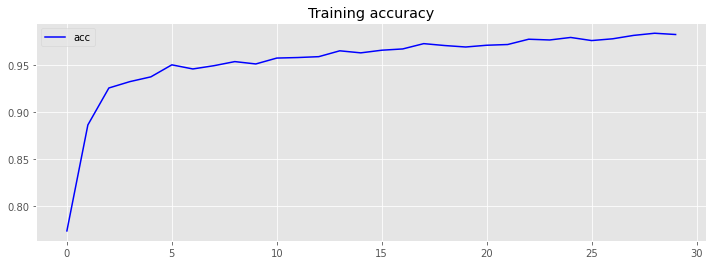

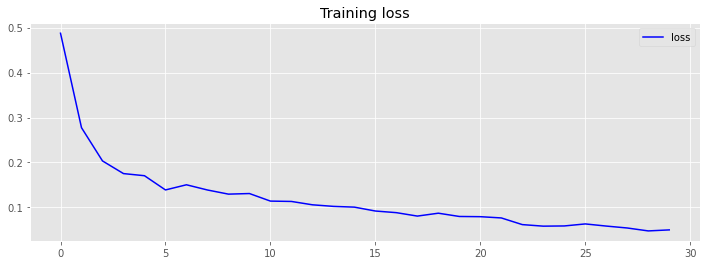

In [ ]:
plt.style.use('ggplot')
acc = history2.history['acc']
loss = history2.history['loss']
epochs = range(len(acc))
plt.figure(figsize=[12,4])
plt.plot(epochs, acc, 'b-', label='acc')
plt.title('Training accuracy')
plt.legend()
plt.figure(figsize=[12,4])
plt.plot(epochs, loss, 'b-', label='loss')
plt.title('Training loss')
plt.legend()
plt.show()

The accuracy with just 50% of the dataset is over 96% (training acc).  Let's see how it performs with new data.

In [ ]:
end = datetime.datetime.now()
elapsed = end - start
print('Training took a total of {}'.format(elapsed))

Training took a total of 0:50:05.880652


In [ ]:
test_generator = test_datagen.flow_from_directory(test_folder, 
                                                  target_size=(150, 150), 
                                                  batch_size=32, 
                                                  class_mode='binary')

test_loss, test_acc = model2.evaluate_generator(test_generator, steps=20)
print('test acc:', test_acc)

Found 585 images belonging to 2 classes.
test acc: 0.96875


After reducing the number of epochs to 50 (from 100 and then 80) I retained 95.9% accuracy on the test set.  This is practically unchanged from the 100 epochs which had clear overfitting.  I altered the batch size and steps, and was able to get it up to about 97%

In [ ]:
3# LETS GET SOME RESULTS
# my labels are backwards 0 instead of 1 for pneumonia
# fixed here, but should go back and repair earlier.  Also noted there.
# Basically, my model was trained backwards, but results are same.

results_train = model2.evaluate(train_images, train_y)
print(results_train)

test_y_inverse = np.array([1 if x==0 else 0 for x in test_y])
results_test = model2.evaluate(test_images, test_y)
print(results_test)

147/147 [==============================] - 2s 12ms/step - loss: 0.0387 - acc: 0.9874
[0.03872412443161011, 0.9874066114425659]
19/19 [==============================] - 0s 11ms/step - loss: 0.0611 - acc: 0.9778
[0.06107121706008911, 0.9777777791023254]


##Save Model

In [ ]:
#model2.save('/content/drive/MyDrive/chest_xray/chest_xray_cnn_100_801010.h5')


#MODEL 3: CNN with Dropout
I wanted to try an advanced strategy.  The options I considered, and may still attempt are:
- dropout
- cropping the images to focus on lungs
- undersampling to fix weighting
- oversampling the normal images
- image augmentation with brightness/rotation etc.

I started with 0.5 dropout on all layers after maxpool.  I reduced to 0.2, and eventually dropped two of the dropouts until accuracy improved.


In [44]:
# I want to try a dropout strategy.  Not sure if it applies here

model3 = models.Sequential()

model3.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model3.add(layers.MaxPooling2D((2, 2)))

model3.add(layers.Conv2D(64, (3, 3), activation='relu'))
model3.add(layers.MaxPooling2D((2, 2)))

model3.add(layers.Conv2D(128, (3, 3), activation='relu'))
model3.add(layers.MaxPooling2D((2, 2)))
model3.add(SpatialDropout2D(0.2))

model3.add(layers.Conv2D(128, (3, 3), activation='relu'))
model3.add(layers.MaxPooling2D((2, 2)))
model3.add(SpatialDropout2D(0.2))

model3.add(layers.Flatten())
model3.add(layers.Dense(512, activation='relu'))
model3.add(layers.Dense(1, activation='sigmoid'))

##Training

Used the same setup as previous CNN model

In [45]:
# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255) # this scaling should prevent errors of local maxima minima and get better results
test_datagen = ImageDataGenerator(rescale=1./255)


# we are going to do another generator for our data.  Not for our test though, we need that to be normal
train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_folder,
        # All images will be resized to 150x150, same as baseline
        target_size=(150, 150),
        batch_size=32,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(val_folder,
                                                        target_size=(150, 150),
                                                        batch_size=32,
                                                        class_mode='binary')



Found 4685 images belonging to 2 classes.
Found 585 images belonging to 2 classes.


In [46]:
model3.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

Reduced the number of epochs and implemented dropout layers to hopefully prevent overfitting which appears to occur around 50 epochs in.

In [47]:
history3 = model3.fit_generator(train_generator, 
                              steps_per_epoch=100, 
                              epochs=30, 
                              validation_data=validation_generator, 
                              validation_steps=15)

Epoch 1/30
100/100 [==============================] - 637s 6s/step - loss: 0.5537 - acc: 0.7432 - val_loss: 0.3761 - val_acc: 0.8833
Epoch 2/30
100/100 [==============================] - 147s 1s/step - loss: 0.3266 - acc: 0.8702 - val_loss: 0.3431 - val_acc: 0.8313
Epoch 3/30
100/100 [==============================] - 68s 678ms/step - loss: 0.2317 - acc: 0.9098 - val_loss: 0.1726 - val_acc: 0.9292
Epoch 4/30
100/100 [==============================] - 49s 494ms/step - loss: 0.2030 - acc: 0.9170 - val_loss: 0.1619 - val_acc: 0.9396
Epoch 5/30
100/100 [==============================] - 42s 419ms/step - loss: 0.1735 - acc: 0.9349 - val_loss: 0.2358 - val_acc: 0.9042
Epoch 6/30
100/100 [==============================] - 38s 379ms/step - loss: 0.1712 - acc: 0.9359 - val_loss: 0.1411 - val_acc: 0.9417
Epoch 7/30
100/100 [==============================] - 37s 375ms/step - loss: 0.1583 - acc: 0.9388 - val_loss: 0.1519 - val_acc: 0.9396
Epoch 8/30
100/100 [==============================] - 37s 3

##Evaluation

In [48]:
loss, acc = model3.evaluate(train_images, train_y)
print("Train loss: {}\nTrain accuracy: {}".format(loss, acc))

print()
loss, acc = model3.evaluate(test_images, test_y)
print("Test loss: {}\nTest accuracy: {}".format(loss, acc))

147/147 [==============================] - 1s 10ms/step - loss: 0.0547 - acc: 0.9829
Train loss: 0.05467898026108742
Train accuracy: 0.982924222946167

19/19 [==============================] - 0s 11ms/step - loss: 0.0740 - acc: 0.9692
Test loss: 0.07404985278844833
Test accuracy: 0.9692307710647583


The dropout layers added 0.5% to the performance of the model with same even with fewer epochs.  It improved the model slightly and is now our prefered model.

##Save Model

In [ ]:
model3.save('/content/drive/MyDrive/chest_xray/chest_xray_cnn_dropout2_100_801010.h5')


f = open('/content/drive/MyDrive/chest_xray/history3.pkl', 'wb')
pickle.dump(history3, f)

# with open('content/drive/MyDrive/chest_xray/hist3.pkl', 'rb') as f:
#     history3 = pickle.load(f)


#MODEL 4: CNN with Dropout (Cropped images)
During EDA on images, it was clear that there are unnecessary edges on all of our images.  After looking at a handful of images, I decided I could cut off 10px on every side of image and not sacrifice any lung pixels.


## Crop images

I ended up cropping it to 128px instead to so I could add one more layer to my model.

In [ ]:
# crop down images as experiment
print(train_images[0].shape)
crop_train_images = np.array([x[6:134, 11:139, :] for x in train_images]) # height, width, channels
print(crop_train_images[0].shape)

crop_test_images = np.array([x[6:134, 11:139, :] for x in test_images])

crop_val_images = np.array([x[6:134, 11:139, :] for x in val_images])

(150, 150, 3)
(128, 128, 3)


## Build Model

Dropout strategy did not work on the cropped images.  Smaller images combined with dropout left less raw data to start with.  

On the bright side, this model ran very quickly.

In [ ]:
# I want to try a dropout strategy.  Not sure if it applies here
# Way faster.  Tried different kernel sizes, and nodes

model4 = models.Sequential()

model4.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(128, 128, 3)))
model4.add(layers.MaxPooling2D((2, 2)))


model4.add(layers.Conv2D(64, (3, 3), activation='relu'))
model4.add(layers.MaxPooling2D((2, 2)))

model4.add(layers.Conv2D(128, (3, 3), activation='relu'))
model4.add(layers.MaxPooling2D((2, 2)))


model4.add(layers.Conv2D(128, (3, 3), activation='relu'))
model4.add(layers.MaxPooling2D((2, 2)))
#model4.add(SpatialDropout2D(0.2))


model4.add(layers.Conv2D(256, (3, 3), activation='relu'))
model4.add(layers.MaxPooling2D((2, 2)))


# cannot add another layer unless I up the image size, MaxPools are shrinking outputs by 1/2

model4.add(layers.Flatten())
model4.add(layers.Dense(512, activation='relu'))
model4.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
model4.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

## Train Model
Reduced the number of epochs and implemented dropout layers to hopefully prevent overfitting which appears to occur around 60 or 70 epochs in.

In [ ]:
history4 = model4.fit(crop_train_images,  
                        train_y,
                        batch_size=24,
                        steps_per_epoch=120, 
                        epochs=31, 
                        validation_data=(crop_val_images, val_y), 
                        validation_steps=20)

Epoch 1/31
120/120 [==============================] - 2s 17ms/step - loss: 0.5473 - acc: 0.7399 - val_loss: 0.4084 - val_acc: 0.8562
Epoch 2/31
120/120 [==============================] - 2s 16ms/step - loss: 0.3880 - acc: 0.8221 - val_loss: 0.3182 - val_acc: 0.8813
Epoch 3/31
120/120 [==============================] - 2s 16ms/step - loss: 0.3182 - acc: 0.8583 - val_loss: 0.2536 - val_acc: 0.8729
Epoch 4/31
120/120 [==============================] - 2s 16ms/step - loss: 0.2791 - acc: 0.8836 - val_loss: 0.2082 - val_acc: 0.9167
Epoch 5/31
120/120 [==============================] - 2s 16ms/step - loss: 0.2629 - acc: 0.8916 - val_loss: 0.2313 - val_acc: 0.8958
Epoch 6/31
120/120 [==============================] - 2s 16ms/step - loss: 0.2311 - acc: 0.9076 - val_loss: 0.1669 - val_acc: 0.9312
Epoch 7/31
120/120 [==============================] - 2s 16ms/step - loss: 0.2011 - acc: 0.9193 - val_loss: 0.1838 - val_acc: 0.9271
Epoch 8/31
120/120 [==============================] - 2s 16ms/step - 

##Evaluate Model

In [ ]:
# same inverse problem as before
loss, acc = model4.evaluate(crop_train_images, train_y)
print("Train loss: {}\nTrain accuracy: {}".format(loss, acc))

print()
loss, acc = model4.evaluate(crop_test_images, test_y)
print("Test loss: {}\nTest accuracy: {}".format(loss, acc))

147/147 [==============================] - 1s 8ms/step - loss: 0.0645 - acc: 0.9744
Train loss: 0.06452083587646484
Train accuracy: 0.9743863344192505

19/19 [==============================] - 0s 7ms/step - loss: 0.0973 - acc: 0.9607
Test loss: 0.0972597599029541
Test accuracy: 0.9606837630271912


96% was the best I could tune it using the hyperparameters.

In [ ]:
model4.save('/content/drive/MyDrive/chest_xray/chest_xray_cnn_crop_100_801010.h5')


Make a quick evaluator for new images

#MODEL 5: CNN With Image Augmentation
This will be the 5th and final model.  Adding image augmentation to the mix.  

This method was attempted on 50% of the data, and took too long to run.  It is likely a good method for much smaller data set.

In [ ]:
# I want to try a dropout strategy.  Not sure if it applies here

model5 = models.Sequential()


model5.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model5.add(layers.MaxPooling2D((2, 2)))
model5.add(layers.Conv2D(64, (3, 3), activation='relu'))
model5.add(layers.MaxPooling2D((2, 2)))
model5.add(layers.Conv2D(128, (3, 3), activation='relu'))
model5.add(layers.MaxPooling2D((2, 2)))
model5.add(layers.Flatten())
model5.add(layers.Dense(512, activation='relu'))
model5.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
model5.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

In [ ]:

train_datagen = ImageDataGenerator(rotation_range=10, 
                                   width_shift_range=0.2, 
                                   height_shift_range=0.2, 
                                   shear_range=0.2, 
                                   brightness_range=[0.8,1.2]
                                   zoom_range=0.2, 
                                   horizontal_flip=False, 
                                   fill_mode='nearest'
                                   
                                   )

# same test_datagen from previous models.  Just repeated in case not cached.
test_datagen = ImageDataGenerator(rescale=1./255)

# This is the same train_generator from previous models
train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_folder,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=32,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(val_folder, 
                                                        target_size=(150, 150), 
                                                        batch_size=32, 
                                                        class_mode='binary')



Found 4685 images belonging to 2 classes.
Found 585 images belonging to 2 classes.


In [ ]:

history5 = model5.fit_generator(train_generator, 
                              steps_per_epoch=50, 
                              epochs=20, 
                              validation_data=validation_generator, 
                              validation_steps=15)



This configuration did not improve the results, but may be acceptable for smaller datasets.

In [ ]:
# save to google drive
model5.save('/content/drive/MyDrive/chest_xray/chest_xray_augCNN_100_801010.h5')

In [ ]:
loss, acc = model5.evaluate(train_images, train_y)
print("Train loss: {}\nTrain accuracy: {}".format(loss, acc))

print()
loss, acc = model5.evaluate(test_images, test_y)
print("Test loss: {}\nTest accuracy: {}".format(loss, acc))

#BEST MODEL


## Load Model

Load and test the best model.  Model 3, CNN with Dropout performed the best for us when measured for accuracy.

In [ ]:
# we can now load the saved model

model_path = '/content/drive/MyDrive/chest_xray/chest_xray_cnn_dropout_100_801010.h5'


my_model = load_model(model_path)

with open('content/drive/MyDrive/chest_xray/history.pkl', 'rb') as f:
    my_history = pickle.load(f)

I plan on productionizing the model, and want to test it out in the same way it will be used in the app.  This bit of code iterates through my test images and evaluates them.  If they match, they get a smiley.  We should see lots of smileys and very few X's.

## Production Model Testing

In [64]:
correct = 0
incorrect = 0

incorrect_images = []

print("{:12}{:12}{:12}{:12}".format('Label', 'Prediction', 'Float', 'Correct?'))

# go through some images and predict them individually.
for i in range(len(test_images)):
  img_orig = test_images[i]
  #print(img.shape)
  img = img_orig.reshape(-1, 150,150, 3)

  #print(type(test_labels[i][0]))
  if test_labels[i][1] > 0:
    image_label = 'NORMAL'
  else:
    image_label = 'PNEUMONIA'
  #image_label = 'NORMAL' if test_labels[i][1] == 0 else 'PNEUMONIA'


  result = my_model.predict(img)
  pred_float = result[0][0]

  if result[0].round() > 0:
    prediction = 'NORMAL'
  else:
    prediction = 'PNEUMONIA'  
  
  print('{:12}{:12}{:<12.2f}'.format(image_label, prediction, pred_float), end=' ')

  if prediction == image_label:
    correct += 1
    print("\U0001F603") 
  else:
    incorrect += 1
    print(u'\u274C')
    incorrect_images.append([img_orig, prediction, pred_float, image_label])

print('Correct: {}'.format(correct))
print('Incorrect: {}'.format(incorrect))

print(correct / (correct + incorrect))

Label       Prediction  Float       Correct?    
PNEUMONIA   PNEUMONIA   0.05         😃
PNEUMONIA   PNEUMONIA   0.00         😃
NORMAL      NORMAL      1.00         😃
PNEUMONIA   PNEUMONIA   0.01         😃
NORMAL      NORMAL      1.00         😃
NORMAL      NORMAL      1.00         😃
NORMAL      NORMAL      1.00         😃
NORMAL      NORMAL      1.00         😃
PNEUMONIA   PNEUMONIA   0.00         😃
NORMAL      NORMAL      0.64         😃
NORMAL      NORMAL      1.00         😃
NORMAL      NORMAL      1.00         😃
NORMAL      NORMAL      1.00         😃
NORMAL      NORMAL      1.00         😃
NORMAL      NORMAL      1.00         😃
NORMAL      NORMAL      1.00         😃
NORMAL      NORMAL      1.00         😃
PNEUMONIA   PNEUMONIA   0.25         😃
NORMAL      NORMAL      1.00         😃
PNEUMONIA   PNEUMONIA   0.39         😃
NORMAL      NORMAL      1.00         😃
NORMAL      NORMAL      1.00         😃
NORMAL      NORMAL      0.97         😃
NORMAL      NORMAL      0.99         😃
NORMAL      NOR

##Miscategorized Images
Characteristics of  images miscategorized by the model.
- Mostly “Landscape” oriented (skinny lungs after resize)
- Significant black edges compared to most images
- Infants over represented
- Numerical uncertainty by model 
- Blurry or low contrast images
- Most can be corrected by image preprocessing (crop)


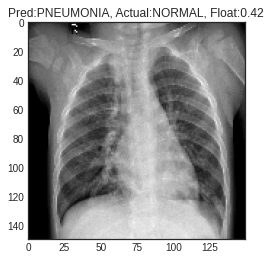

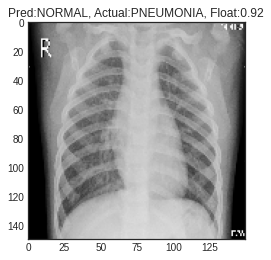

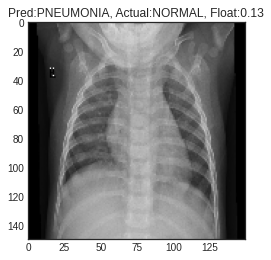

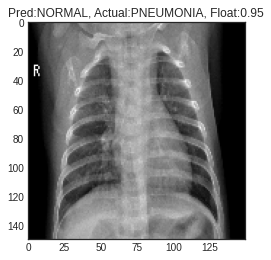

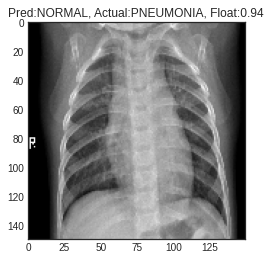

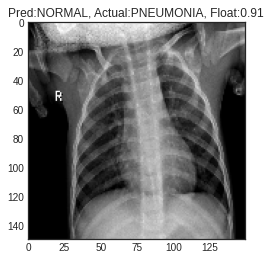

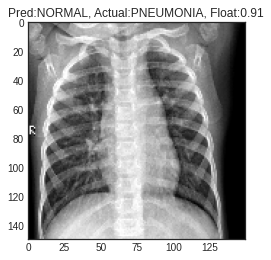

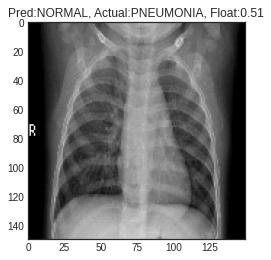

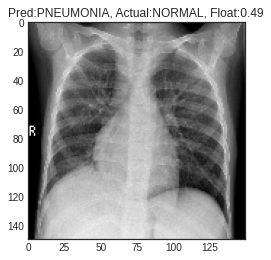

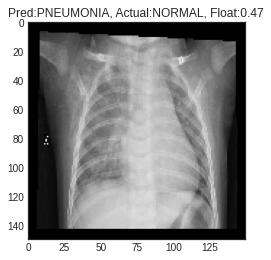

In [ ]:
# What kind of misses did we get?
plt.style.use('seaborn-white')

for img, prediction, pred_float, result in incorrect_images:
  plt.imshow(img)
  plt.title("Pred:{}, Actual:{}, Float:{:.2f}".format(prediction, result, pred_float))
  plt.show()

It is interesting to see the missed images.  Lots of infants.  Lots of pneumonia looking haze which was actualy vascular taking up a large portion of chest.  A few of them have faces showing where the mouth might be confused for a feature.  Most of the numerical predictions were not 0 or 1.  Perhaps a doctor could flag these results as inconclusive. 

In [ ]:
# CONFUSION MATRIX AND SCORING

preds = my_model.predict(test_images) # Use your best model. For CNN I used test_images, for baseline I used test_img
#acc = accuracy_score(test_y, np.round(preds))*100 
acc = (accuracy_score(test_y, np.round(preds)))*100  # my test_y is backwards for model2!!
cm = confusion_matrix(test_y, np.round(preds))
tn, fn, fp, tp = cm.ravel()

print('Confusion matrix')
print(cm)

print('\nMETRICS:')
precision = tp/(tp+fp)*100
recall = tp/(tp+fn)*100
print('Accuracy: {:.2f}%'.format(acc))
print('Precision: {:.2f}%'.format(precision))
print('Recall: {:.2f}%'.format(recall))
print('F1-score: {:.2f}'.format(2*precision*recall/(precision+recall)))


Confusion matrix
[[152   6]
 [  4 423]]

METRICS:
Accuracy: 98.29%
Precision: 99.06%
Recall: 98.60%
F1-score: 98.83


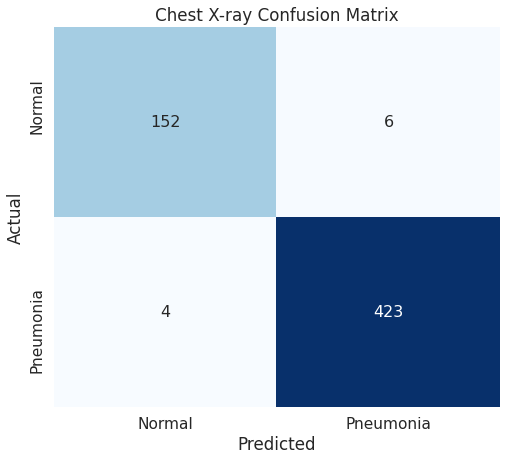

In [ ]:
 df_cm = pd.DataFrame(cm, columns=np.unique(test_y), index = np.unique(test_y))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (8,7))
sns.set(font_scale=1.4) #for label size
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16}, fmt='g', cbar=False)# font size
plt.xticks([0.5, 1.5], ['Normal', 'Pneumonia'])
plt.yticks([0.3, 1.4], ['Normal', 'Pneumonia'])
plt.title('Chest X-ray Confusion Matrix')
plt.savefig('/content/drive/MyDrive/chest_xray/confusion_matrix.png', transparent=True)

The confusion matrix shows that the misses lean towards predicting pneumonia.  In all models, the precision was higher than accuracy which is likely the correct assumption for a serious medical condition.  For this reason, no effort was made to weight the dataset by over/under sampling.  

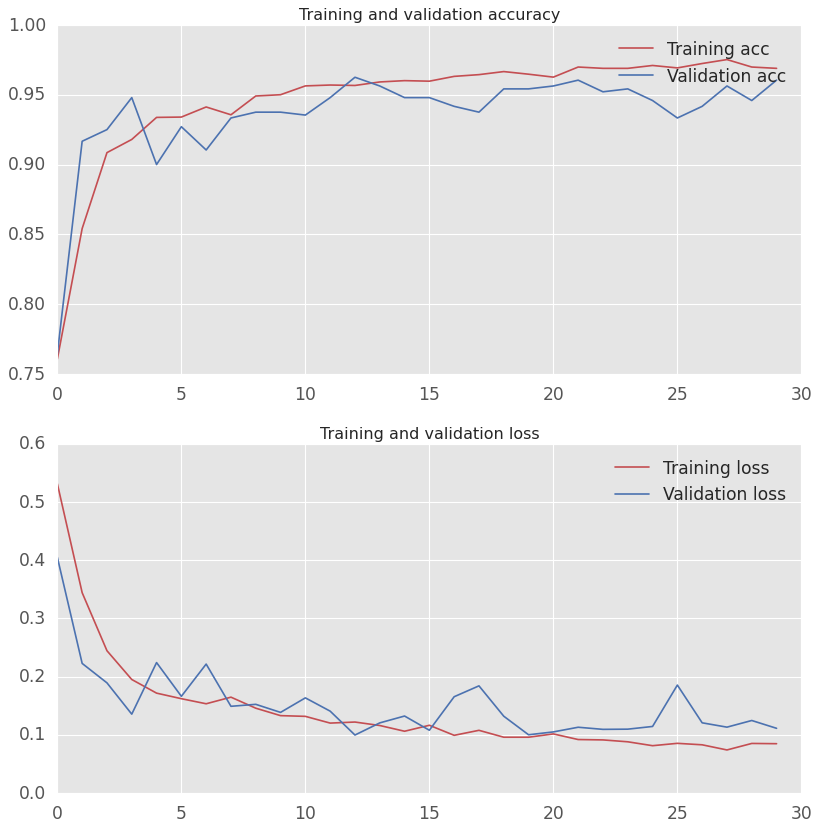

In [ ]:
plt.style.use('ggplot')

plt.figure(figsize=[12,12])
plt.subplot(211)
acc = my_hist.history['acc']
val_acc = my_hist.history['val_acc']
loss = my_hist.history['loss']
val_loss = my_hist.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.subplot(212)
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

# CONCLUSION

Model 3, CNN Dropout, was the most successful when measured for accuracy.

It performed at 98.3% accuracy on the test set, with a 99.1% precision score.  That is the model deployed on the web app.  When rerun, the model achieved 97.7%, but all iterations were between 97-98.

To increase the accuracy and improve the model, we could:
- use bigger image size >150x150
- use larger kernel on CNN
- change the images in preprocessing (change brightness crop), maybe use open cv / pillow.
- Further tune the model hyperparameters
- add more images to the set
